# ML with clean SDSS sample.

---

## Python setup

First, we install and import the packages to be used

In [1]:
!pip install scikit-learn==0.23.2

!pip install "tune-sklearn>=0.2.1"
!pip install "scikit-optimize>=0.8.1"

!pip install ppscore

!pip install sklearn-som
!pip install umap
!pip install trimap
!pip install "pacmap==0.4"

!pip install cmasher
!pip install colorcet
!pip install mpl-scatter-density

!pip install "xgboost>=1.1.0"
!pip install "catboost>=0.23.2"
!pip install shap
!pip install pycaret

     |████████████████████████████████| 6.8 MB 5.1 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 40 kB 4.0 MB/s 
     |████████████████████████████████| 51.6 MB 40 kB/s 
     |████████████████████████████████| 10.1 MB 48.3 MB/s 
     |████████████████████████████████| 72 kB 509 kB/s 
     |████████████████████████████████| 127 kB 71.7 MB/s 
     |████████████████████████████████| 1.3 MB 48.8 MB/s 
     |████████████████████████████████| 3.1 MB 54.2 MB/s 
     |████████████████████████████████| 78 kB 6.4 MB/s 
     |████████████████████████████████| 65 kB 3.4 MB/s 
     |████████████████████████████████| 124 kB 50.8 MB/s 
     |████████████████████████████████| 142 kB 72.9 MB/s 
     |████████████████████████████████| 294 kB 53.1 MB/s 
     |████████████████████████████████| 85 kB 3.3 MB/s 
  

**Important**: We need to restart Google's runtime for the new packages to be properly linked after installation.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import mpl_scatter_density
from astropy.table import Table, join
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, classification_report
import ppscore as pps
import seaborn as sns
import cmasher as cmr
import colorcet as cc
import getpass
import pacmap
import umap
import trimap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn_som import som
import pandas as pd
import re
import shap
import pycaret.regression as pyr
# import missingno as msno
import os
import subprocess

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [2]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [3]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [4]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methods to deal with loaded Pycaret models.

In [5]:
def get_final_column_names(pycaret_pipeline, sample_df):
    for (name, method) in pycaret_pipeline.named_steps.items():
        if method != 'passthrough' and name != 'trained_model':
            print(f'Running {name}')
            sample_df = method.transform(sample_df)
    return sample_df.columns.tolist()

In [6]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    try:
        variables = pycaret_pipeline["trained_model"].feature_importances_
        
    except:
        variables = np.mean([
                        tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_ 
            if hasattr(tree, 'feature_importances_')
                        ], axis=0)
    
    coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
    sorted_df = (
        coef_df.sort_values(by='Importance', ascending=False)
        .head(n)
        .sort_values(by='Importance', ascending=True).reset_index(drop=True)
    )
    return sorted_df

Define specific metric for redshift values:  

$$
\Delta z = \mathrm{median}\left(\frac{|(z_{True} - z_{Predict})|}{(1 + z_{True})}\right)
$$

In [7]:
def delta_z(y, y_pred, **kwargs):
    num = np.abs(y - y_pred)
    den = 1 + y
    return np.nanmedian(num / den)

---

## Reading data

First, let's download the fits file with the data.

In [8]:
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Pr_slP0EWMSbx0nTc4ttohnKPJGzmiqU' -O SDSSQ_DR16_only_pos_mags.fits

In [9]:
file_name = 'SDSSQ_DR16_only_pos_mags.fits'  # 4743 objects

In [10]:
if not os.path.exists(file_name):
    subprocess.run(['wget', '--no-check-certificate',\
                    'https://docs.google.com/uc?export=download&id=1Pr_slP0EWMSbx0nTc4ttohnKPJGzmiqU',\
                    '-O', file_name], check=True, text=True)

In [11]:
machine  = getpass.getuser()
cat_path = ''  # relative path to the same directory

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

In [12]:
large_catalog_full_tab = Table.read(cat_path + file_name, format='fits')

In [13]:
large_catalog_full_tab.info

<Table length=4743>
   name    dtype 
--------- -------
SDSS_NAME bytes18
       RA float64
      DEC float64
        Z float64
 PSFMAG_u float32
 PSFMAG_g float32
 PSFMAG_r float32
 PSFMAG_i float32
 PSFMAG_z float32
      FUV float64
      NUV float64
   W1_MAG float32
   W2_MAG float32
     JMAG float64
     HMAG float64
     KMAG float64

In [14]:
zero_point_star_equiv  = u.zero_point_flux(3631.1 * u.Jy)  # zero point (AB) to Jansky

In [15]:
nmgy_cols = ['FUV', 'NUV']

for col in nmgy_cols:
    large_catalog_full_tab[col].unit        = u.nanomaggy
    large_catalog_full_tab[col + '_MAG'] = u.Magnitude(large_catalog_full_tab[col].to(u.AB, zero_point_star_equiv))
    # large_catalog_full_tab[col] = large_catalog_full_tab[col].to(u.mJy)

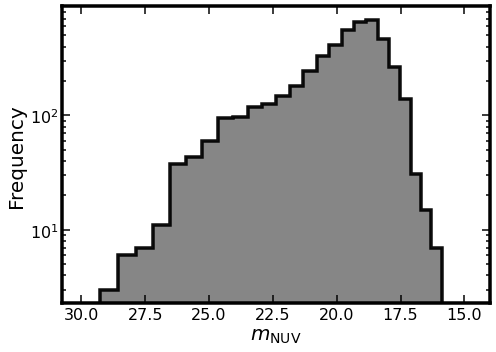

In [16]:
fig             = plt.figure(figsize=(7,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

binss = np.logspace(np.nanmin(np.log10(large_catalog_full_tab['NUV_MAG'])),\
                    np.nanmax(np.log10(large_catalog_full_tab['NUV_MAG'])), 30)
ax1.hist(large_catalog_full_tab['NUV_MAG'], bins=binss, fc='Gray', ec='k', histtype='stepfilled', alpha=0.95, lw=3.5);

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$m_{\mathrm{NUV}}$', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.invert_xaxis()
#ax1.set_xlim(left=0.2, right=2.4)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

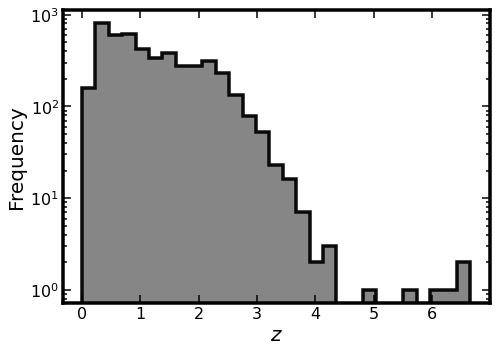

In [17]:
fig             = plt.figure(figsize=(7,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

used_col        = 'Z'

bins_z = np.linspace(np.nanmin(large_catalog_full_tab[used_col]),\
                    np.nanmax(large_catalog_full_tab[used_col]), 30)
ax1.hist(large_catalog_full_tab[used_col], bins=bins_z, fc='Gray', ec='k', histtype='stepfilled', alpha=0.95, lw=3.5);

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$z$', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
#ax1.set_xlim(left=0.2, right=2.4)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

Mask invalid entries in X-ray fluxes.

Many magnitudes in this catalogue are in the Vega system.  
We will transform them into the AB system.

For Vega WISE magnitudes, we have the following conversion to AB values.

Conversion to the AB system (from [WISE documentation](https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html),  
and [Jarrett et al., 2017](https://ui.adsabs.harvard.edu/abs/2017ApJ...836..182J/abstract))

($m_{\mathrm{AB}} = m_{\mathrm{Vega}} + \Delta (m)$)

|Band | magnitude offset (Δm)|
|-----|---------------------:|
|W1   |                 2.699|
|W2   |                 3.339|
|W3   |                 5.174|
|W4   |                 6.620|

With UKIDSS, we can use the information from [Hewett et al., 2006](https://ui.adsabs.harvard.edu/abs/2006MNRAS.367..454H/abstract)

|Band | magnitude offset (Δm)|
|-----|---------------------:|
|J    |                 0.938|
|H    |                 1.379|
|K    |                 1.900|

Convert `Vega` magnitudes to `AB`.

In [18]:

vega_cols     = ['W1_MAG', 'W2_MAG', 'JMAG', 'HMAG', 'KMAG']
vega_shift    = {'W1_MAG': 2.699, 'W2_MAG': 3.339, 'JMAG': 0.938, 'HMAG': 1.379, 'KMAG': 1.900}


for col in vega_cols:
    large_catalog_full_tab[col] += vega_shift[col]

Create `pandas` DataFrame from `astropy` table.

In [19]:

# large_catalog_full_df = large_catalog_full_tab.to_pandas(use_nullable_int=False)
large_catalog_full_df = large_catalog_full_tab.to_pandas()

Create `pandas`DataFrames for redhisft and coordinates.

In [20]:
redshift_df           = large_catalog_full_df['Z']
coord_ra_deg          = large_catalog_full_df['RA']
coord_dec_deg         = large_catalog_full_df['DEC']

Create `pandas` Series with coordinates.

In [21]:
# coords_arr            = pd.Series(SkyCoord(coord_ra_deg, coord_dec_deg, unit=u.degree), index=coord_ra_deg.index)

Calculate colours for several pairs of magnitudes in the sample.

In [22]:
# colours_df                   = pd.DataFrame()
large_catalog_full_df['u_g']            = large_catalog_full_df['PSFMAG_u'] - large_catalog_full_df['PSFMAG_g']
large_catalog_full_df['g_r']            = large_catalog_full_df['PSFMAG_g'] - large_catalog_full_df['PSFMAG_r']
large_catalog_full_df['r_i']            = large_catalog_full_df['PSFMAG_r'] - large_catalog_full_df['PSFMAG_i']
large_catalog_full_df['i_z']            = large_catalog_full_df['PSFMAG_i'] - large_catalog_full_df['PSFMAG_z']
large_catalog_full_df['u_r']            = large_catalog_full_df['PSFMAG_i'] - large_catalog_full_df['PSFMAG_r']  # ~U-V
large_catalog_full_df['g_i']            = large_catalog_full_df['PSFMAG_g'] - large_catalog_full_df['PSFMAG_i']
large_catalog_full_df['w1_w2']          = large_catalog_full_df['W1_MAG']   - large_catalog_full_df['W2_MAG']
large_catalog_full_df['J_H']            = large_catalog_full_df['JMAG']     - large_catalog_full_df['HMAG']
large_catalog_full_df['H_K']            = large_catalog_full_df['HMAG']     - large_catalog_full_df['KMAG']
large_catalog_full_df['FUV_NUV']        = large_catalog_full_df['FUV_MAG']  - large_catalog_full_df['NUV_MAG']

# colours_df.describe()

In [23]:
np.shape(large_catalog_full_df)

(4743, 28)

## Possible correlations

---

In [24]:
print(large_catalog_full_df.columns)

Index(['SDSS_NAME', 'RA', 'DEC', 'Z', 'PSFMAG_u', 'PSFMAG_g', 'PSFMAG_r',
       'PSFMAG_i', 'PSFMAG_z', 'FUV', 'NUV', 'W1_MAG', 'W2_MAG', 'JMAG',
       'HMAG', 'KMAG', 'FUV_MAG', 'NUV_MAG', 'u_g', 'g_r', 'r_i', 'i_z', 'u_r',
       'g_i', 'w1_w2', 'J_H', 'H_K', 'FUV_NUV'],
      dtype='object')


In [25]:
cols2corr = ['Z', 'PSFMAG_u', 'PSFMAG_g', 'PSFMAG_r', 'PSFMAG_i', 'PSFMAG_z', 'FUV_MAG',\
             'NUV_MAG', 'W1_MAG', 'W2_MAG', 'JMAG', 'HMAG', 'KMAG', 'u_g', 'g_r', 'r_i',\
             'i_z', 'u_r', 'g_i', 'w1_w2', 'J_H', 'H_K', 'FUV_NUV']  # From main dataframe (large_catalog_full_df)

In [26]:
corr_data_df                   = large_catalog_full_df.loc[:, cols2corr]

In [27]:
corr_data_df.columns

Index(['Z', 'PSFMAG_u', 'PSFMAG_g', 'PSFMAG_r', 'PSFMAG_i', 'PSFMAG_z',
       'FUV_MAG', 'NUV_MAG', 'W1_MAG', 'W2_MAG', 'JMAG', 'HMAG', 'KMAG', 'u_g',
       'g_r', 'r_i', 'i_z', 'u_r', 'g_i', 'w1_w2', 'J_H', 'H_K', 'FUV_NUV'],
      dtype='object')

Scale features for plotting correlations.

In [28]:
# max_abs_scaler = MaxAbsScaler()
min_max_scaler = MinMaxScaler(feature_range=(0., 1.))
# x_scaled = max_abs_scaler.fit_transform(large_catalog_df.values)
x_scaled = min_max_scaler.fit_transform(corr_data_df.values)
norm_corr_data_df = pd.DataFrame(data=x_scaled, columns=corr_data_df.columns, index=corr_data_df.index) 

Restore redshift values (since they are the target feature).

In [29]:
norm_corr_data_df['Z'] = corr_data_df['Z']

Calculate correlation values.

In [30]:
correlation = norm_corr_data_df.corr()

Show 25 largest correlations.

In [31]:
correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:25]

FUV_NUV   FUV_NUV     1.000000
PSFMAG_r  PSFMAG_i    0.969595
W2_MAG    W1_MAG      0.968843
PSFMAG_r  PSFMAG_g    0.960337
PSFMAG_i  PSFMAG_z    0.952530
PSFMAG_r  PSFMAG_z    0.929043
PSFMAG_i  PSFMAG_g    0.906670
PSFMAG_u  PSFMAG_g    0.897501
g_r       g_i         0.888749
PSFMAG_g  PSFMAG_z    0.859105
PSFMAG_u  PSFMAG_r    0.818632
g_i       u_r         0.786056
r_i       g_i         0.786056
HMAG      JMAG        0.778112
KMAG      HMAG        0.768318
PSFMAG_u  PSFMAG_i    0.763041
W1_MAG    KMAG        0.751791
u_g       PSFMAG_u    0.737905
FUV_MAG   NUV_MAG     0.729590
JMAG      PSFMAG_z    0.711763
          PSFMAG_i    0.711211
PSFMAG_u  PSFMAG_z    0.710004
JMAG      KMAG        0.702259
          PSFMAG_r    0.688708
KMAG      W2_MAG      0.683595
dtype: float64

For this example, we are not dropping any feature at this point by correlation coefficients.

Let's plot the correlation values.

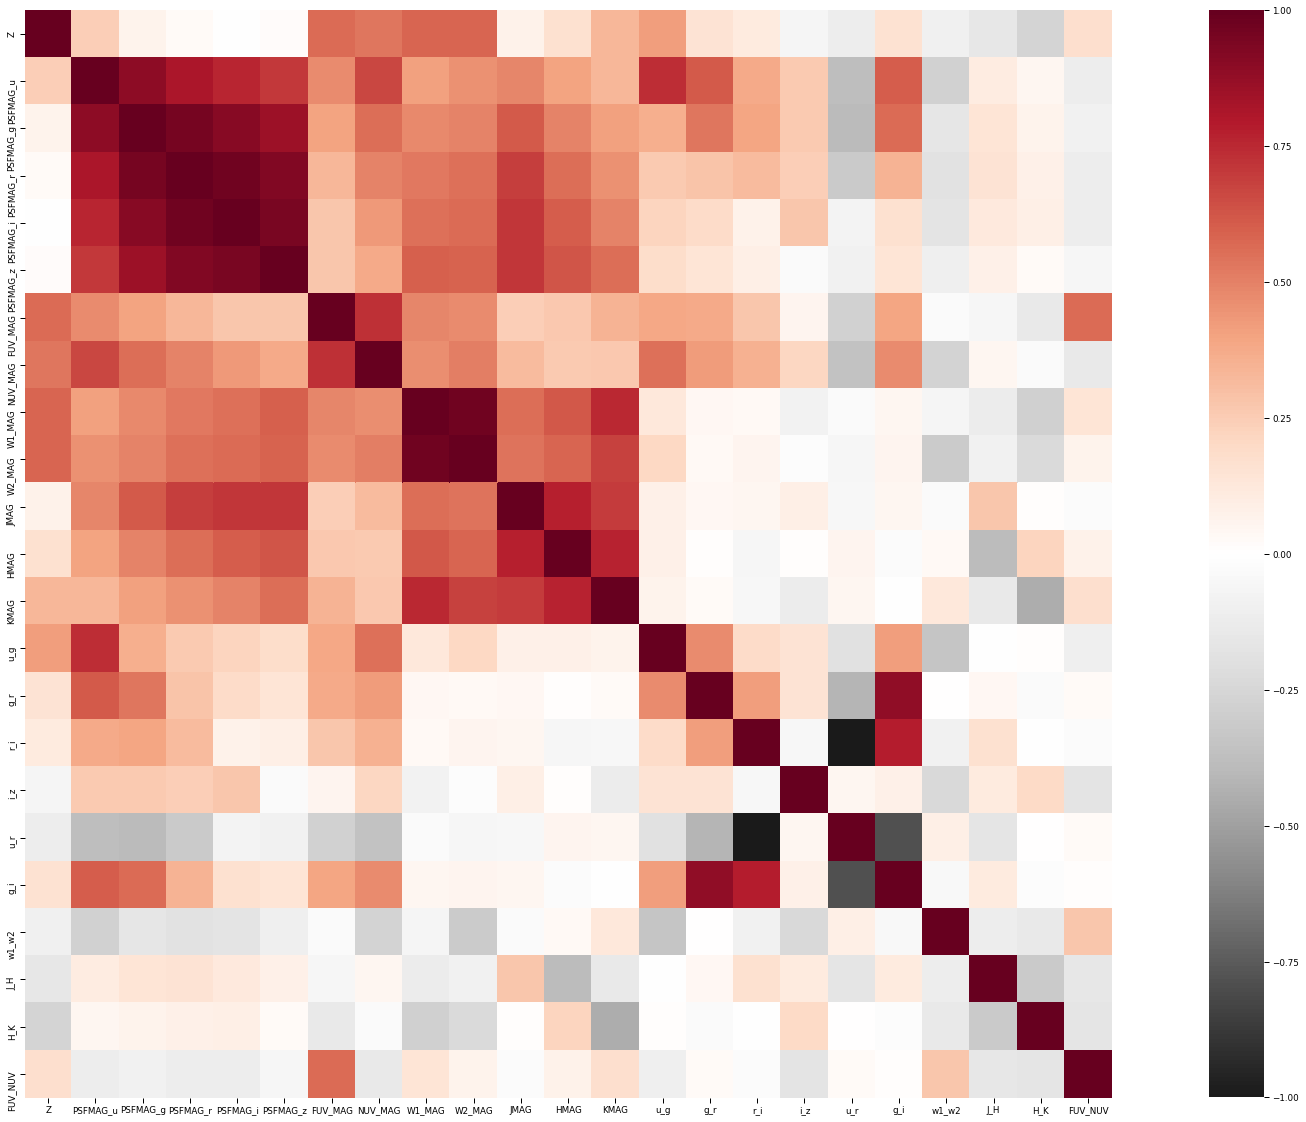

In [32]:
plt.figure(figsize=(35,20))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
sns.heatmap(correlation, annot=False, cmap=plt.cm.RdGy_r, center=0.0, square=True)

Now, we can calculate the Predicting Power Score (ppscore, https://github.com/8080labs/ppscore)

In [33]:
pps_matrix = pps.matrix(norm_corr_data_df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

Text(768.9000000000004, 0.5, 'target')

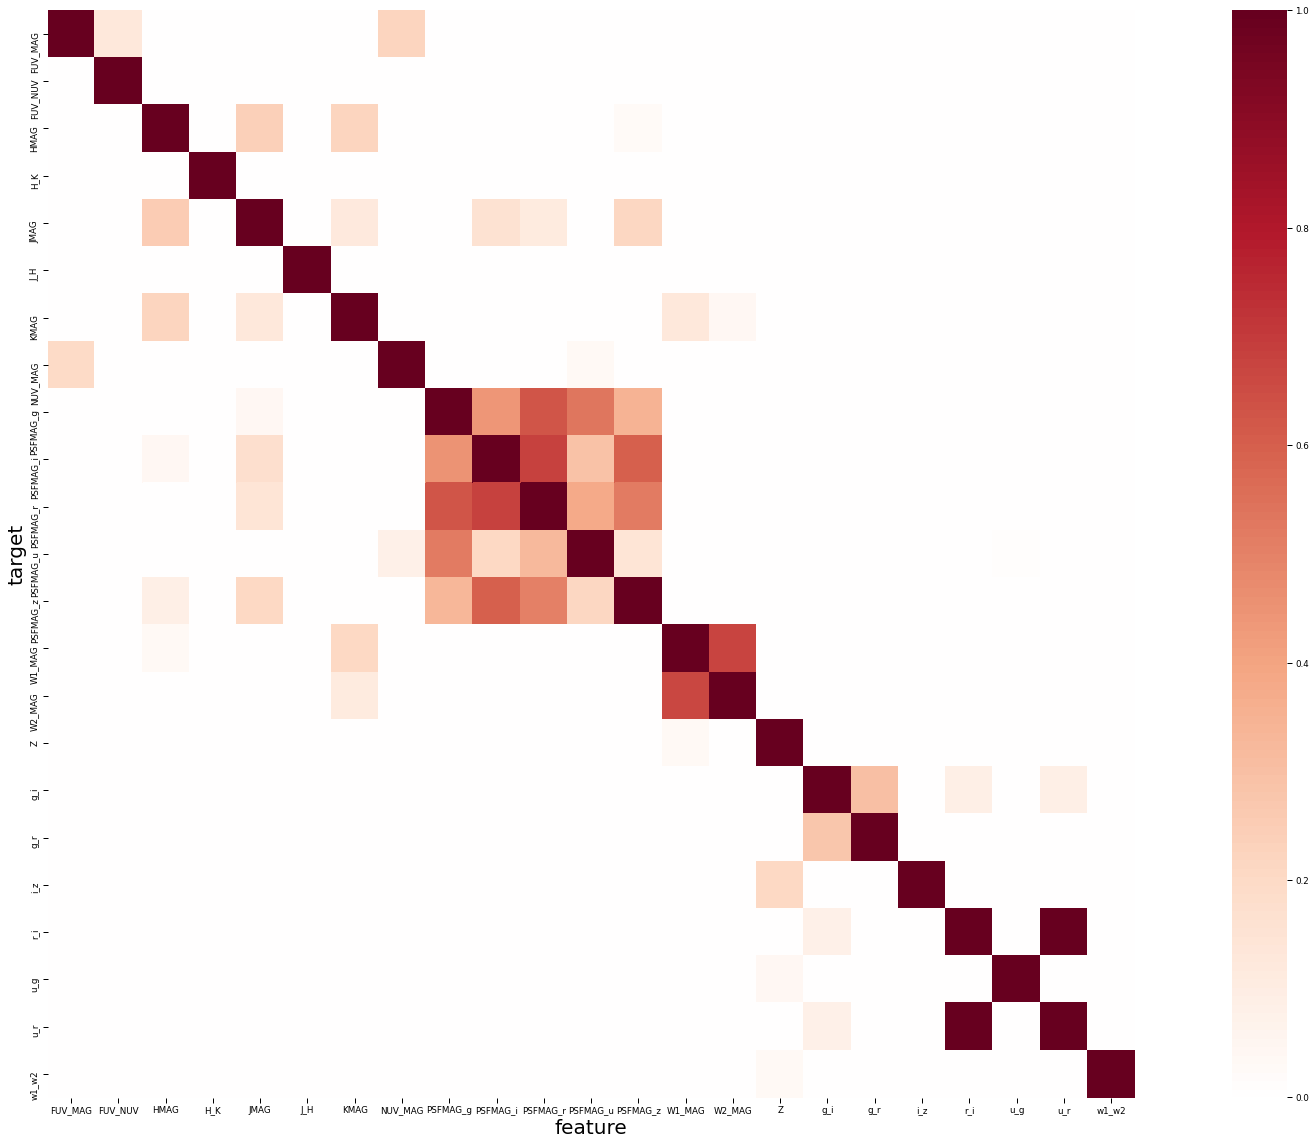

In [34]:
plt.figure(figsize=(35,20))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(pps_matrix, annot=False, cmap=plt.cm.RdGy_r, center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('target')

Twenty highest PPS values.

In [35]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y       
w1_w2     w1_w2       1.000000
u_r       r_i         0.992523
PSFMAG_r  PSFMAG_i    0.681534
PSFMAG_i  PSFMAG_r    0.681007
W2_MAG    W1_MAG      0.673472
W1_MAG    W2_MAG      0.666541
PSFMAG_g  PSFMAG_r    0.627887
PSFMAG_r  PSFMAG_g    0.626817
PSFMAG_z  PSFMAG_i    0.599703
PSFMAG_i  PSFMAG_z    0.594950
PSFMAG_u  PSFMAG_g    0.535501
PSFMAG_g  PSFMAG_u    0.522558
PSFMAG_z  PSFMAG_r    0.521012
PSFMAG_r  PSFMAG_z    0.500348
PSFMAG_g  PSFMAG_i    0.451256
PSFMAG_i  PSFMAG_g    0.442791
PSFMAG_u  PSFMAG_r    0.380264
PSFMAG_z  PSFMAG_g    0.348296
PSFMAG_g  PSFMAG_z    0.333644
PSFMAG_r  PSFMAG_u    0.320805
dtype: float64

## Dimensionality reduction

In [36]:
norm_corr_data_df.columns

Index(['Z', 'PSFMAG_u', 'PSFMAG_g', 'PSFMAG_r', 'PSFMAG_i', 'PSFMAG_z',
       'FUV_MAG', 'NUV_MAG', 'W1_MAG', 'W2_MAG', 'JMAG', 'HMAG', 'KMAG', 'u_g',
       'g_r', 'r_i', 'i_z', 'u_r', 'g_i', 'w1_w2', 'J_H', 'H_K', 'FUV_NUV'],
      dtype='object')

There is no need to fill empty values. This catalogue does not have NaNs.

In [37]:
# filled_norm_corr_data_df = norm_corr_data_df.fillna(0.0)

Let's set a random seed for future aplications.

In [38]:
seed = 42

## Using t-SNE

In [39]:
feat_red_tsne = TSNE(n_components=2, perplexity=20, metric='cosine', random_state=seed, n_jobs=-1)

## Using UMAP

In [40]:
feat_red_umap = umap.UMAP(n_neighbors=30, n_components=2, random_state=seed)

## Using PacMap

In [41]:
feat_red_pacmap = pacmap.PaCMAP(n_dims=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0)

## Using Trimap

In [42]:
feat_red_trimap = trimap.TRIMAP(n_inliers=20)

TRIMAP(n_inliers=20, n_outliers=5, n_random=5, distance=euclidean, lr=1000.0, n_iters=400, weight_adj=500.0, apply_pca=True, opt_method=dbd, verbose=True, return_seq=False)


## Using SOM

In [43]:
feat_red_som = som.SOM(m=1, n=2, dim=22, random_state=seed)

## Using PCA

In [44]:
feat_red_pca = PCA(n_components=2)

### Select method

In [45]:
selected_feat_red = [feat_red_tsne, feat_red_umap, feat_red_pacmap, feat_red_trimap, feat_red_som, feat_red_pca]
feat_red_names    = ['t-SNE', 'UMAP', 'PacMAP', 'Trimap', 'SOM', 'PCA']

In [46]:
# fit the data (The index of transformed data corresponds to the index of the original data)
X_transformed = {}
for method in np.arange(6):
    if method == 2:  # pacmap
        X_transformed[method] = selected_feat_red[method].fit_transform(norm_corr_data_df.drop(axis=1,\
                                                                                               columns=['Z']).to_numpy(), init='pca')
    elif method == 4:  # SOM
        X_transformed[method] = selected_feat_red[method].fit_transform(norm_corr_data_df.drop(axis=1,\
                                                                                               columns=['Z']).to_numpy(), epochs=3)
    else:
        X_transformed[method] = selected_feat_red[method].fit_transform(norm_corr_data_df.drop(axis=1,\
                                                                                               columns=['Z']).to_numpy())

running TriMap on 4743 points with dimension 22
pre-processing
found nearest neighbors
sampled triplets
running TriMap with dbd
Iteration:  100, Loss: 337.112, Violated triplets: 0.0677
Iteration:  200, Loss: 325.527, Violated triplets: 0.0654
Iteration:  300, Loss: 322.767, Violated triplets: 0.0648
Iteration:  400, Loss: 320.655, Violated triplets: 0.0644
Elapsed time: 0:00:09.994616


In [47]:
X_transformed_df = {}

for method in np.arange(6):
    X_transformed_df[method] = pd.DataFrame(X_transformed[method], columns=['X1', 'X2'])

Just for testing purposes, we can convert some of the redshift values into NaNs, as to see how to plot them.

In [55]:
copy_z_df = large_catalog_full_df.loc[:, 'Z'].copy()
copy_z_df.loc[copy_z_df.sample(frac=0.25).index] = np.nan

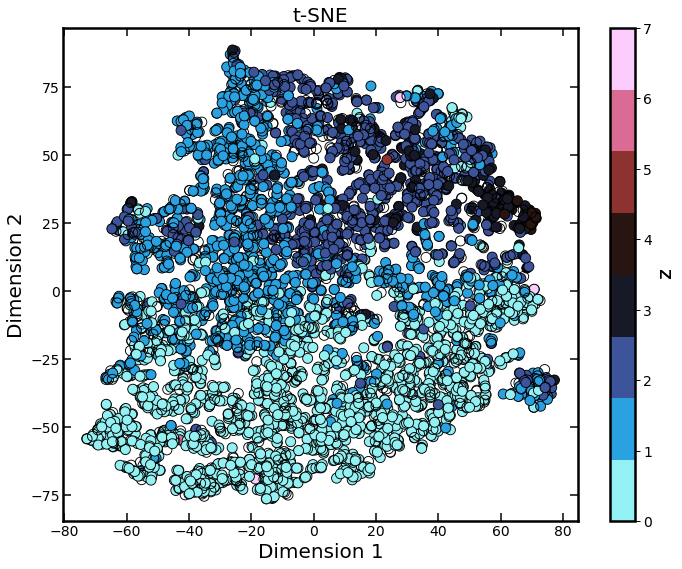

In [57]:
# visualize the embedding
fig             = plt.figure(figsize=(10,8))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

used_m = 0  # t-SNE

norm_z = mcolors.Normalize(vmin=np.floor(np.nanmin(large_catalog_full_df.loc[:, 'Z'])),\
                           vmax=np.ceil(np.nanmax(large_catalog_full_df.loc[:, 'Z'])))
range_z = int(np.ceil(np.nanmax(large_catalog_full_df.loc[:, 'Z'])) -\
             np.floor(np.nanmin(large_catalog_full_df.loc[:, 'Z'])) + 1)

# Using .sample(frac=1) we can be sure that the plotting order of the points will
# be randomised
sc_p = ax1.scatter(X_transformed_df[used_m].loc[:, 'X1'].sample(frac=1, random_state=seed),\
                   X_transformed_df[used_m].loc[:, 'X2'].sample(frac=1, random_state=seed),\
                   c=copy_z_df.sample(frac=1, random_state=seed),\
                   cmap=cm.get_cmap('cmr.redshift', range_z), s=100, ec='k', lw=0.9, norm=norm_z,\
                   plotnonfinite=True)

clb             = plt.colorbar(sc_p)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('z', size=20, path_effects=pe2)

ax1.set_xlabel('Dimension 1', fontsize=20)
ax1.set_ylabel('Dimension 2', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_ylim(top=0.03)
#ax1.set_ylim(bottom=1e-4)
# ax1.set_xlim(left=min_full_eddr, right=max_full_eddr)
ax1.set_title('t-SNE', fontsize=20)
fig.tight_layout()

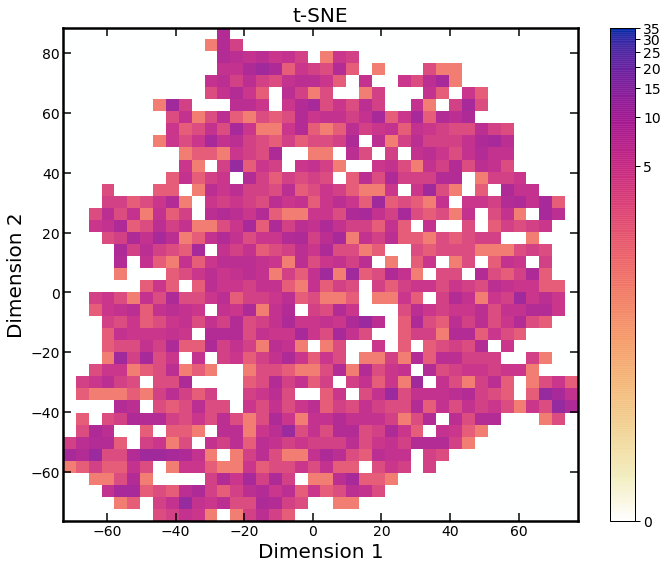

In [52]:
# visualize the embedding
fig             = plt.figure(figsize=(10,8))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear', projection='scatter_density')

used_m = 0

# Modify vmax to match with scatter density results (colorbar & dpi).
norm = ImageNormalize(vmin=0., vmax=35, stretch=LogStretch())

dens_1 = ax1.scatter_density(X_transformed_df[used_m].loc[:, 'X1'],\
            X_transformed_df[used_m].loc[:, 'X2'], cmap=plt.get_cmap('cet_CET_L17'),\
             zorder=0, dpi=6, norm=norm, alpha=0.93)


clb = plt.colorbar(dens_1)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Points per pixel', size=20, path_effects=pe2)

ax1.set_xlabel('Dimension 1', fontsize=20)
ax1.set_ylabel('Dimension 2', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_ylim(top=0.03)
#ax1.set_ylim(bottom=1e-4)
# ax1.set_xlim(left=min_full_eddr, right=max_full_eddr)
ax1.set_title('t-SNE', fontsize=20)
fig.tight_layout()

Now, we can compare all six dimensionality reduction methods.

Text(0, 0.5, 'Redshift')

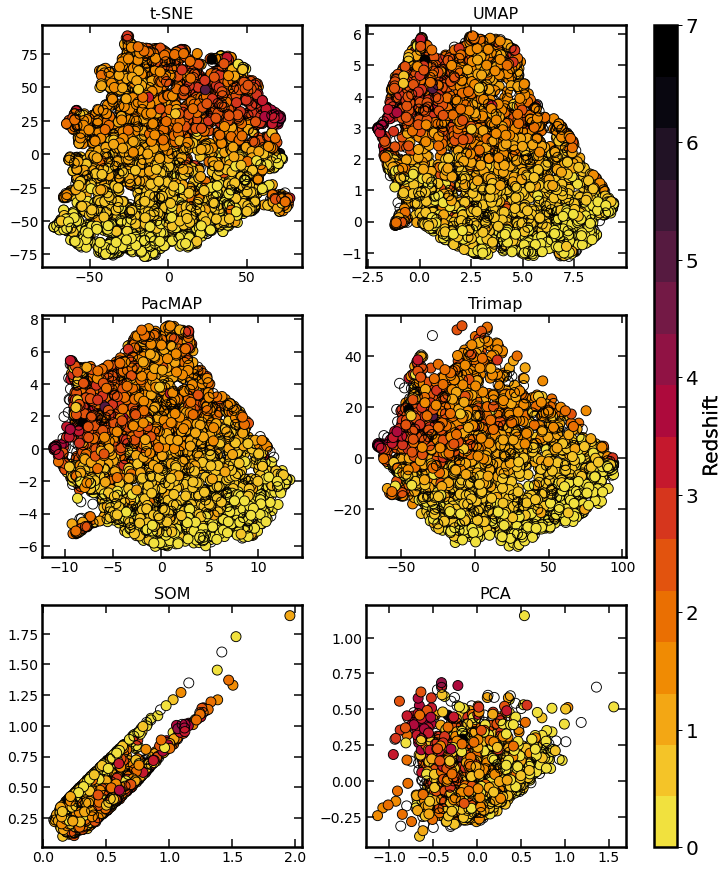

In [59]:
n_rows = 3
n_cols = 2

fig             = plt.figure(figsize=(5 * n_cols, 4 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.1, wspace=0.1)
axs             = {}

norm_z = mcolors.Normalize(vmin=np.floor(np.nanmin(large_catalog_full_df.loc[:, 'Z'])),\
                           vmax=np.ceil(np.nanmax(large_catalog_full_df.loc[:, 'Z'])))
range_z = int(np.ceil(np.nanmax(large_catalog_full_df.loc[:, 'Z'])) -\
             np.floor(np.nanmin(large_catalog_full_df.loc[:, 'Z'])) + 1)

for count in np.arange(6):
    axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)])

    sc_p = axs[count].scatter(X_transformed_df[count].loc[:, 'X1'].sample(frac=1, random_state=seed),\
                   X_transformed_df[count].loc[:, 'X2'].sample(frac=1, random_state=seed),\
                   c=copy_z_df.sample(frac=1, random_state=seed),\
                   cmap=cm.get_cmap('cmr.ember_r', range_z * 2), s=100, ec='k', lw=0.9,\
                    norm=norm_z, plotnonfinite=True)
    
    axs[count].tick_params(which='both', top=True, right=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    axs[count].set_title(feat_red_names[count], fontsize=16)
    
clb            = plt.colorbar(cm.ScalarMappable(norm=norm_z,\
                                                cmap=cm.get_cmap('cmr.ember_r', range_z * 2)),\
                              ax=[axs[key] for key in axs], fraction=.09, aspect=30)
clb.ax.tick_params(labelsize=20)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Redshift', size=20, path_effects=pe2)

# fig.supxlabel('Dimension 1', fontsize=40)
# fig.supylabel('Dimension 2', fontsize=40)

---

# Using Pycaret

We will start with the non-normalised data. We will let PyCaret (https://pycaret.org) do it for us.

In order to test more capabilities, we will divide our data into three sub-samples: train, test, and validation sets.  

PyCaret will use tran and test sets and we will let a $10\%$ of the data for final validation (not touched by the models).

PyCaret can take, automatically, a $70\%$ of the data for training and a $30\%$ for testing.

It will also perform most of its training routines using 10-fold CV.

In [ ]:
data_train_test_df = corr_data_df.sample(frac=0.90, random_state=seed)  # Train + test sets
data_validation_df = corr_data_df.drop(data_train_test_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {corr_data_df.shape}')
print(f'Data for Modeling (Train and Test): {data_train_test_df.shape}')
print(f'Unseen Data For Validation: {data_validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (4743, 23)
Data for Modeling (Train and Test): (4269, 23)
Unseen Data For Validation: (474, 23)
----------------------------------------


Now, we set PyCaret up. There are several options, and some of them might be different depending on whether we are running regression, classification, or other tasks (https://pycaret.readthedocs.io/en/latest/api/regression.html).

We will let PyCaret select the most relevant features by using the Boruta method (https://danielhomola.com/feature%20selection/phd/borutapy-an-all-relevant-feature-selection-method/).  

Also, we want to normalise our training features (not the target) with zscores (i.e., each feature will have a mean value, mu=0, and a standard deviation, sigma=1).

There are many more options (https://pycaret.readthedocs.io/en/latest/api/regression.html#pycaret.regression.setup).

In [ ]:
exp_mclf = pyr.setup(data=data_train_test_df, target='Z', session_id=seed, silent=True,\
                     feature_selection=True, feature_selection_method='boruta',\
                     n_jobs=-1, normalize=True, normalize_method='zscore')

,Description,Value
0,session_id,42
1,Target,Z
2,Original Data,"(4269, 23)"
3,Missing Values,False
4,Numeric Features,22
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(2988, 20)"


We can see, from the output, that some features have been discarded. This might help our models to run faster.

At this point, we add our custom scoring function for redshifts.

In [ ]:
pyr.add_metric('z_met', 'delta z', delta_z, greater_is_better=False)

Name                                                       delta z
Display Name                                               delta z
Score Function                <function delta_z at 0x7fe784227b90>
Scorer               make_scorer(delta_z, greater_is_better=False)
Target                                                        pred
Args                                                            {}
Greater is Better                                            False
Custom                                                        True
Name: z_met, dtype: object

Just to have more information, we see the models that are available for use in the system.

In [ ]:
pyr.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


Now, instead of looking at some text to understand what models are better for our regression problem and the structure of our data, we can ask PyCaret to, quickly, test many models and select the ones that behave the best for us.

We want to stack (https://en.wikipedia.org/wiki/Ensemble_learning#Stacking) the five best models, so we are selecting them directly from the comparison. Also, some models are excluded from this task since, from previous runs, they behave really bad.

In [ ]:
top5 = pyr.compare_models(n_select=5, exclude=['huber', 'lar', 'llar', 'lasso', 'en'], sort='z_met')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,delta z,TT (Sec)
rf,Random Forest Regressor,0.1677,0.1076,0.3206,0.8308,0.1366,0.3544,0.0363,3.093
knn,K Neighbors Regressor,0.1667,0.1076,0.3202,0.8312,0.1350,0.3397,0.0365,0.074
et,Extra Trees Regressor,0.1588,0.0937,0.2976,0.8531,0.1281,0.3537,0.0380,1.285
dt,Decision Tree Regressor,0.2376,0.2762,0.5151,0.5590,0.2060,0.4122,0.0414,0.066
lightgbm,Light Gradient Boosting Machine,0.1782,0.1049,0.3158,0.8351,0.1359,0.3794,0.0496,0.323
catboost,CatBoost Regressor,0.1764,0.0968,0.3029,0.8483,0.1304,0.3672,0.0508,8.647
xgboost,Extreme Gradient Boosting,0.1909,0.1172,0.3374,0.8152,0.1424,0.3944,0.0509,4.955
gbr,Gradient Boosting Regressor,0.2147,0.1273,0.3516,0.7997,0.1512,0.4308,0.0649,1.280
ridge,Ridge Regression,0.2936,0.1770,0.4167,0.7211,0.1883,0.5640,0.1019,0.019
lr,Linear Regression,0.2934,0.1771,0.4168,0.7209,0.1883,0.5638,0.1020,0.369


At this step, we let PyCaret stack the models we have just selected. The best model will be used as meta model, using the outputs of the other four models as new features.

In [ ]:
pyr_stacked = pyr.stack_models(estimator_list=top5[1:], meta_model=top5[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE,delta z
0,0.1135,0.0481,0.2193,0.9217,0.0939,0.1242,0.0239
1,0.1320,0.1445,0.3802,0.7788,0.1264,0.1291,0.0257
2,0.1163,0.0698,0.2642,0.8955,0.1083,0.1191,0.0224
3,0.1332,0.0670,0.2588,0.8956,0.1229,0.2108,0.0293
4,0.1514,0.2084,0.4565,0.6894,0.1586,0.1680,0.0279
5,0.1420,0.0845,0.2907,0.8705,0.1432,1.5971,0.0266
6,0.1263,0.0560,0.2366,0.8948,0.1165,0.1926,0.0254
7,0.1359,0.0912,0.3019,0.8501,0.1427,0.2352,0.0260
8,0.1025,0.0366,0.1913,0.9407,0.0906,0.1427,0.0262
9,0.1028,0.0340,0.1843,0.9485,0.0859,0.1351,0.0267


If we didn't want to stack models, we could have just used the best-performing model.

In [ ]:
# pyr_model  = top5[0]

Now, we can tune the hyperparameters of the selected (stacked) model. This step should take quite a long time.

In [ ]:
tuned_stacked = pyr.tune_model(pyr_stacked, early_stopping='asha', optimize='z_met')

,MAE,MSE,RMSE,R2,RMSLE,MAPE,delta z
0,0.1285,0.0496,0.2228,0.9193,0.0969,0.1409,0.0330
1,0.1409,0.1431,0.3783,0.7809,0.1273,0.1448,0.0332
2,0.1253,0.0698,0.2642,0.8955,0.1066,0.1199,0.0269
3,0.1483,0.0760,0.2756,0.8815,0.1272,0.2081,0.0346
4,0.1649,0.2162,0.4650,0.6778,0.1621,0.1693,0.0285
5,0.1441,0.0720,0.2683,0.8897,0.1305,1.5622,0.0308
6,0.1232,0.0469,0.2166,0.9119,0.1007,0.1641,0.0292
7,0.1385,0.0736,0.2712,0.8790,0.1259,0.1962,0.0289
8,0.1251,0.0445,0.2110,0.9279,0.0981,0.1637,0.0343
9,0.1168,0.0420,0.2050,0.9363,0.0913,0.1460,0.0306


After being tuned, we can see the model's properties. We can see PyCaret configurations, the meta-model parameters and the individual estimators' parameters as well.

In [ ]:
print(tuned_stacked)

StackingRegressor(cv=KFold(n_splits=10, random_state=RandomState(MT19937) at 0x7FE78144D270,
   shuffle=False),
                  estimators=[('knn',
                               KNeighborsRegressor(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=-1, n_neighbors=5,
                                                   p=2, weights='uniform')),
                              ('et',
                               ExtraTreesRegressor(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_...
                  final_estimator=RandomForestRegressor

We can check how our model is doing, letting PyCaret prepare some plots (https://pycaret.org/plot-model/). Of course, we can also do it by ourselves.

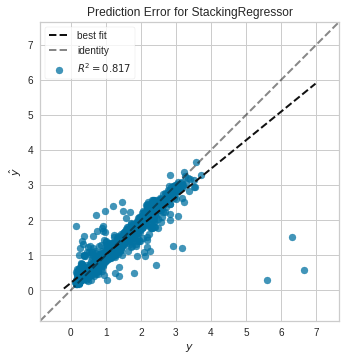

In [ ]:
pyr.plot_model(tuned_stacked, plot='error')

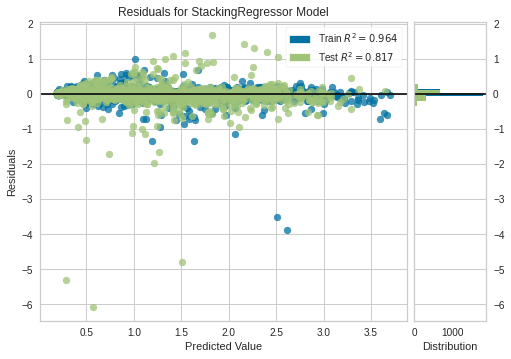

In [ ]:
pyr.plot_model(tuned_stacked, plot='residuals')

If we are satisfied with the results, we can finalise the model. That means, to include the test data into the training set and re-run the models and optimise their parameters.

In [ ]:
final_stacked = pyr.finalize_model(tuned_stacked)

Let's check its parameters:

In [ ]:
print(final_stacked)

StackingRegressor(cv=KFold(n_splits=10, random_state=RandomState(MT19937) at 0x7FE7770635A0,
   shuffle=False),
                  estimators=[('knn',
                               KNeighborsRegressor(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=-1, n_neighbors=5,
                                                   p=2, weights='uniform')),
                              ('et',
                               ExtraTreesRegressor(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_...
                  final_estimator=RandomForestRegressor

---

The model and PyCaret configuration files can be saved and/or downloaded for future use (to avoid extra running time.)

In [ ]:
pyr.save_model(final_stacked, 'model_final_SDSS_z')  # Model (it will be saved with .pkl extension)
pyr.save_config('config_final_SDSS_z')  # Configuration file

Transformation Pipeline and Model Successfully Saved


Now, if we want to load the saved files, we can do it.

In [ ]:
# if not os.path.exists('config_final_SDSS_z'):
#     # Run your code to get the file

In [ ]:
# if not os.path.exists('model_final_SDSS_z.pkl'):
#     # Run your code to get the file

In [ ]:
pyr.load_config('config_final_SDSS_z')

In [ ]:
final_stacked = pyr.load_model('model_final_SDSS_z')

Transformation Pipeline and Model Successfully Loaded


---

Now that our model is complete, we can apply it to the validation set.

First, we can just apply it, without saving the results. That way, we can obtain some statistics on the model.

In [ ]:
pyr.predict_model(final_stacked, data=data_validation_df)

,Z,PSFMAG_u,PSFMAG_g,PSFMAG_r,PSFMAG_i,PSFMAG_z,FUV_MAG,NUV_MAG,W1_MAG,W2_MAG,JMAG,HMAG,KMAG,u_g,g_r,r_i,i_z,u_r,g_i,w1_w2,J_H,H_K,FUV_NUV,Label
4,0.307457,19.738922,19.174831,18.684092,18.569454,18.129286,22.346468,21.036074,16.927895,16.493908,18.320000,17.448000,17.036000,0.564091,0.490740,0.114637,0.440168,-0.114637,0.605377,0.433987,0.872000,0.412001,1.310394,0.610793
16,0.921844,18.032793,18.182171,17.774267,17.897682,17.834732,19.172755,18.337662,16.536222,15.785954,17.376999,17.326000,17.066000,-0.149378,0.407904,-0.123415,0.062950,0.123415,0.284489,0.750268,0.051000,0.259999,0.835093,1.093227
34,0.259557,18.562349,18.528749,18.393641,18.335747,17.887615,19.323493,19.477445,16.581633,16.210674,17.629000,17.290000,17.021000,0.033600,0.135109,0.057894,0.448132,-0.057894,0.193003,0.370958,0.339000,0.269000,-0.153953,0.304411
64,1.868676,18.909988,18.805210,18.451227,18.031166,17.871866,20.886377,20.940173,17.406992,16.891535,17.643000,17.297000,17.597000,0.104778,0.353983,0.420061,0.159300,-0.420061,0.774044,0.515457,0.346000,-0.299999,-0.053796,1.872218
98,1.877000,20.168509,19.650352,19.128874,18.555935,18.318344,23.931509,23.081542,17.307024,16.652020,17.900999,18.379000,17.560000,0.518156,0.521479,0.572939,0.237591,-0.572939,1.094418,0.655005,-0.478001,0.819000,0.849967,1.407639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4694,0.279411,18.025873,17.880335,17.511271,17.485350,16.847416,24.200142,24.687045,15.291117,14.848494,17.250000,16.683000,16.500000,0.145538,0.369064,0.025921,0.637934,-0.025921,0.394985,0.442623,0.567000,0.183000,-0.486903,0.427834
4697,0.890832,18.610174,18.375771,18.210154,18.295279,18.234514,20.709547,18.924801,17.540905,17.100338,17.626999,17.734000,17.937001,0.234404,0.165617,-0.085125,0.060764,0.085125,0.080492,0.440567,-0.107000,-0.203001,1.784746,0.936276
4729,0.439592,19.005405,18.895096,18.898268,18.760256,18.478401,19.519502,19.303298,16.919250,16.601950,18.261999,17.806000,17.375000,0.110310,-0.003172,0.138012,0.281855,-0.138012,0.134840,0.317301,0.455999,0.431000,0.216204,0.447841
4735,1.415235,18.609880,18.312334,18.016172,17.885984,17.873287,22.005297,20.078618,17.217295,16.541204,17.860001,17.558001,17.480000,0.297546,0.296162,0.130188,0.012697,-0.130188,0.426350,0.676090,0.302000,0.078001,1.926679,1.420913


This time, let's save the values. The column **Label** has the predictions.

In [ ]:
unseen_predictions = pyr.predict_model(final_stacked, data=data_validation_df)

We can get some basic statistics.

In [ ]:
unseen_predictions[['Z', 'Label']].describe()

,Z,Label
count,474.000000,474.000000
mean,1.224870,1.194677
std,0.827325,0.751356
min,0.073000,0.196903
25%,0.499638,0.549526
50%,1.039792,1.044979
75%,1.746000,1.657799
max,4.852848,3.562950


And, of course, we can also get a plot comparing our results.

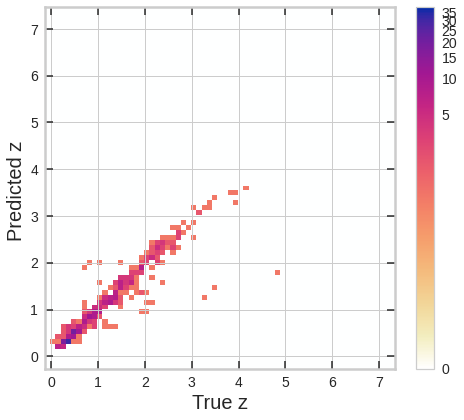

In [ ]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111, projection='scatter_density')


norm = ImageNormalize(vmin=0., vmax=39, stretch=LogStretch())

dens_1 = ax1.scatter_density(unseen_predictions.loc[:, 'Z'].sample(frac=1, random_state=seed),\
            unseen_predictions.loc[:, 'Label'].sample(frac=1, random_state=seed),\
            cmap=plt.get_cmap('cet_CET_L17'), zorder=0, dpi=15, norm=norm, alpha=1)

clb = plt.colorbar(dens_1)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Points per pixel', size=20, path_effects=pe2)

ax1.set_xlabel('True z', fontsize=20)
ax1.set_ylabel('Predicted z ', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=-0.3, right=7.5)
ax1.set_ylim(bottom=-0.3, top=7.5)
ax1.grid(zorder=0)
ax1.set_aspect('equal', 'datalim')
fig.tight_layout()

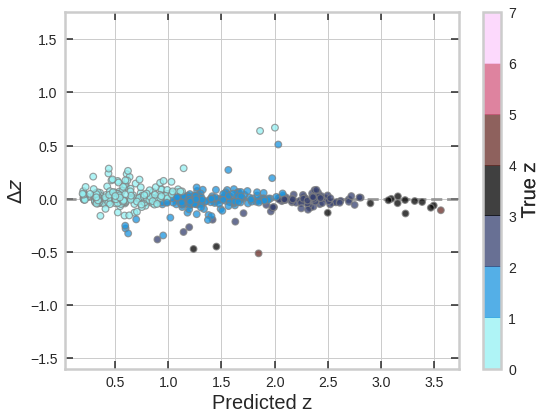

In [ ]:
fig             = plt.figure(figsize=(8,6))
ax1             = fig.add_subplot(111)

norm_z = mcolors.Normalize(vmin=0, vmax=7)

res_z_z     = unseen_predictions.loc[:, 'Label'] - unseen_predictions.loc[:, 'Z']
delt_z      = res_z_z / (1 + unseen_predictions.loc[:, 'Z'])

sc_p = ax1.scatter(unseen_predictions.loc[:, 'Label'].sample(frac=1, random_state=seed),\
                   delt_z.sample(frac=1, random_state=seed),\
                   c=unseen_predictions.loc[:, 'Z'].sample(frac=1, random_state=seed),\
                   s=45, ec='Gray', alpha=0.75, lw=1.2,\
                   cmap=plt.get_cmap('cmr.redshift', 7), zorder=10, norm=norm_z)
ax1.axhline(y=0, ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0)

clb             = plt.colorbar(sc_p)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('True z', size=20, path_effects=pe2)

ax1.set_xlabel('Predicted z', fontsize=20)
ax1.set_ylabel('$\Delta z$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.grid(zorder=0)
ax1.set_aspect('equal', 'datalim')
fig.tight_layout()